## Benchmark 6: OLS model structured bootstrap resampling
Now that we have a resampling strategy that gives us at least some confidence that our internal benchmarking scores could be reflective of what will happened when we submit to the public leaderboard. Let's start working on the model. The first thing I want to try is another shot at the OLS model. Firstly, to see if we can make any clever improvements. But, mostly to generalize the functions written to resample, forecast and score the naive model.
1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Load & inspect](#load_inspect)
3. [Helper functions](#helper_functions)

<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model
+ SMAPE: Symmetric mean absolute percentage error

<a name="load_inspect"></a>
### 2. Load & inspect

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf
#import functions.data_manipulation_functions as data_funcs

import statistics
import numpy as np
import pandas as pd
import statsmodels.api as sm
import multiprocessing as mp
import matplotlib.pyplot as plt
from statistics import NormalDist
from scipy import stats

print(f'Python: {sys.version}')
print()
print(f'Numpy {np.__version__}')
print(f'Pandas {pd.__version__}')

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Numpy 1.23.5
Pandas 1.4.3


In [2]:
# Load parsed data
block_size = 8

output_file = f'{conf.DATA_PATH}/parsed_data/structured_bootstrap_blocksize{block_size}.npy'
timepoints = np.load(output_file)

print(f'Timepoints shape: {timepoints.shape}')
print()
print('Column types:')

for column in timepoints[0,0,0,0:]:
    print(f'\t{type(column)}')

print()
print(f'Example block:\n{timepoints[0,0,0:,]}')

Timepoints shape: (31, 3135, 8, 5)

Column types:
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>

Example block:
[[1.0010000e+03 1.5646176e+18 3.0076818e+00 1.2490000e+03 0.0000000e+00]
 [1.0010000e+03 1.5672960e+18 2.8848701e+00 1.1980000e+03 1.0000000e+00]
 [1.0010000e+03 1.5698880e+18 3.0558431e+00 1.2690000e+03 2.0000000e+00]
 [1.0010000e+03 1.5725664e+18 2.9932332e+00 1.2430000e+03 3.0000000e+00]
 [1.0010000e+03 1.5751584e+18 2.9932332e+00 1.2430000e+03 4.0000000e+00]
 [1.0010000e+03 1.5778368e+18 2.9690900e+00 1.2420000e+03 5.0000000e+00]
 [1.0010000e+03 1.5805152e+18 2.9093256e+00 1.2170000e+03 6.0000000e+00]
 [1.0010000e+03 1.5830208e+18 2.9332314e+00 1.2270000e+03 7.0000000e+00]]


<a name="helper_functions"></a>
### 3. Helper functions

In [3]:
def two_point_smape(actual, forecast):
    '''Takes two datapoints and returns the SMAPE value for the pair'''

    # If SMAPE denominator is zero set SMAPE to zero
    if actual == 0 and forecast == 0:
        return 0

    # Calculate smape for forecast
    smape = abs(forecast - actual) / ((abs(actual) + abs(forecast)) / 2)
    
    return smape

In [4]:
def sample_parsed_data(timepoints, sample_size):
    '''Generates a random sample of sample_size from a random timepoint'''

    # Initialize random seed to make sure that output is differently random each call
    np.random.seed()

    # Pick random timepoint
    random_timepoint_index = np.random.choice(timepoints.shape[0], 1)
    timepoint = timepoints[random_timepoint_index][0]

    if sample_size == 'all':
        return timepoint

    # Pick n unique random county indexes to include in the sample
    random_county_indices = np.random.choice(timepoint.shape[0], sample_size, replace=False)

    # Use random indices to extract sample from timepoint
    sample = timepoint[random_county_indices]

    return sample

In [5]:
def make_forecast(block, model_types, model_order):
    '''Uses specified model type and model order to forecast
    within block, one timepoint into the future. Also returns
    naive, 'carry-forward' prediction for the same datapoint 
    for comparison'''

    # Get prediction for naive control
    naive_prediction = block[(model_order + 1), 2]

    # Add control to results
    results = {'naive_control': naive_prediction}

    # Y input is sequential integers
    x_input = list(range(model_order))

    # X input is MBD values starting from the left
    # edge of the block, up to the model order
    y_input = list(block[:model_order, 2])

    # Forecast X input is sequential integers starting
    # after the end of the X input. Note: we are only interested
    # in the first prediction here, but some statsmodels estimators
    # expect the same dim they were fitted to
    forecast_x = list(range(model_order, (model_order * 2)))

    for model_type in model_types:

        if model_type == 'OLS':

            # Fit and predict
            model = sm.OLS(y_input, sm.add_constant(x_input)).fit()
            prediction = model.predict(sm.add_constant(forecast_x))

            # Collect forecast
            results['OLS'] = prediction[0]

        if model_type == 'TS':

            # Fit Theil-Sen
            ts = stats.theilslopes(y_input, x_input)

            # Calculate forecast from Theil-Sen slope and intercept
            prediction = ts[1] + ts[0] * forecast_x[0]

            # Collect forecast
            results['TS'] = prediction

    return results

In [6]:
def model_smape_score(sample, model_types, model_order):
    '''Takes a sample of blocks, makes forecast for each 
    and collects resulting SMAPE values'''

    # Holder for SMAPE values
    smape_values = {
        'naive_control': []
    }

    for model_type in model_types:
        smape_values[model_type] = []

    for block_num in range(sample.shape[0]):

        # Get the forecasted value(s)
        results = make_forecast(sample[block_num], model_types, model_order)

        # Get the true value
        actual_value = sample[block_num, model_order, 2]

        # Get and collect SMAPE value for the forecasts
        for key, value in results.items():

            smape_value = two_point_smape(actual_value, value)
            smape_values[key].append(smape_value)


    # Calculate smape score for this sample
    smape_scores = {}

    for key, values in smape_values.items():
        smape_score = (100/len(values)) * sum(values)
        smape_scores[key] = smape_score

    return smape_scores

In [7]:
def bootstrap_smape_score(timepoints, num_samples, sample_size, model_order, model_types):

    smape_scores = {'naive_control': []}

    for model_type in model_types:
        smape_scores[model_type] = []

    for i in range(num_samples):
        sample = sample_parsed_data(timepoints, sample_size)
        result = model_smape_score(sample, model_types, model_order)

        for key, value in result.items():
            smape_scores[key].append(value)

    return smape_scores

In [8]:
num_samples = 3000
sample_size = 1000
model_order = 4
model_types = ['OLS', 'TS']
data_column = 2

smape_scores = bootstrap_smape_score(
    timepoints, 
    num_samples, 
    sample_size, 
    model_order, 
    model_types
)

In [19]:
smape_scores_df = pd.DataFrame(smape_scores)
smape_scores_df.describe()

,naive_control,OLS,TS
count,3000.000000,3000.000000,3000.000000
mean,1.791165,2.591758,2.784513
std,1.153340,1.333273,1.351072
min,0.822860,1.271130,1.472167
25%,1.278762,1.792168,1.957278
50%,1.540916,2.257049,2.401014
75%,1.899976,2.734724,2.946896
max,8.783216,9.262029,9.393827


In [31]:
density_plot_data = pd.melt(smape_scores_df, value_vars=['OLS', 'TS', 'naive_control'])
density_plot_data.head()

,variable,value
0,OLS,2.341765
1,OLS,1.979304
2,OLS,2.858167
3,OLS,1.788665
4,OLS,2.483299


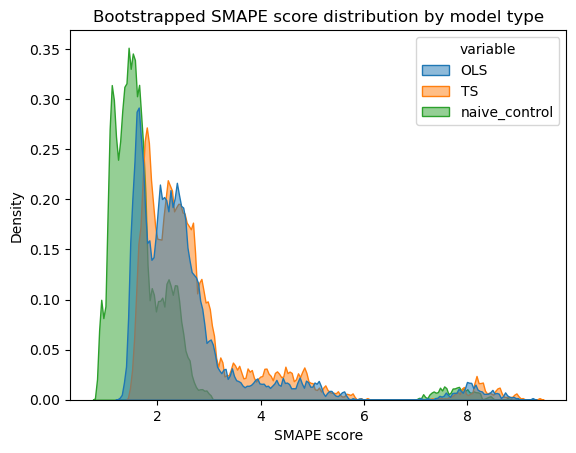

In [36]:
import seaborn as sns

ax = sns.kdeplot(
    data=density_plot_data, 
    x='value',
    hue='variable',
    fill=True,
    alpha=.5,
    bw_adjust=0.1 # type: ignore
)

ax.set(
    xlabel='SMAPE score', 
    ylabel='Density', 
    title='Bootstrapped SMAPE score distribution by model type'
)

sns.move_legend(ax, 'upper right')

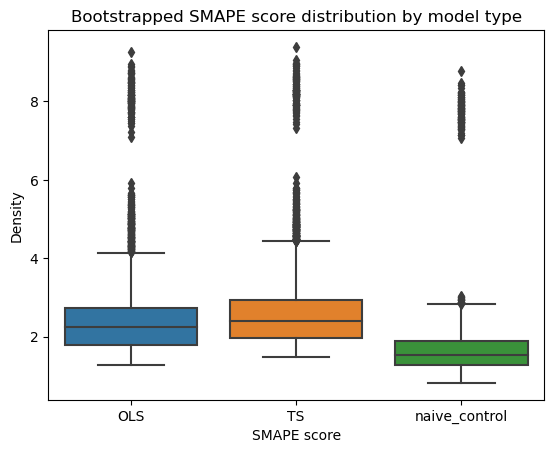

In [44]:
import seaborn as sns

ax = sns.boxplot(
    data=density_plot_data, 
    x='variable',
    y='value'
)

titles = ax.set(
    xlabel='SMAPE score', 
    ylabel='Density', 
    title='Bootstrapped SMAPE score distribution by model type'
)

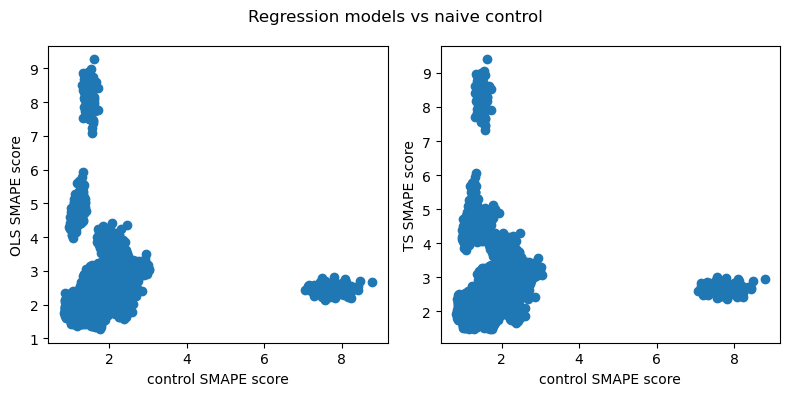

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].scatter(smape_scores['naive_control'], smape_scores['OLS'])
ax[0].set_xlabel('naive SMAPE score')
ax[0].set_ylabel('OLS SMAPE score')

ax[1].scatter(smape_scores['naive_control'], smape_scores['TS'])
ax[1].set_xlabel('naive SMAPE score')
ax[1].set_ylabel('TS SMAPE score')

plt.suptitle('Regression models vs naive control')
plt.tight_layout()

Oooo, this plot is tantalizing - look at the blobs in the lower right and upper left of both plots. We clearly have cases where either the naive model does terribly and the regression model does better and vice versa. If we could somehow pick the right model on the fly without having to see the actual forecast value we could improve this a lot. Part of me wants to spend some time on it, part of me thinks it's time to move on to ARIMA family models and GRUs/LSTMs...

The decision of what model to use would have to be made on the basis of descriptive stats on the input data or diagnostic data about the regression fit. I think the first thing to do would be to recover the samples that are producing those blobs. Not sure that it's worth the time and effort.

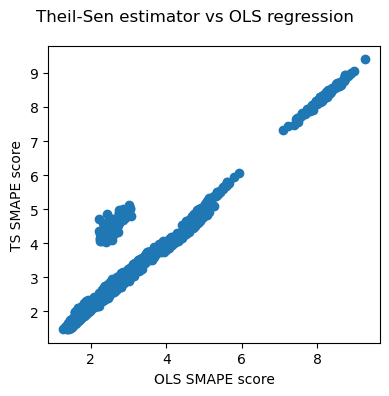

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.scatter(smape_scores['OLS'], smape_scores['TS'])
ax.set_xlabel('OLS SMAPE score')
ax.set_ylabel('TS SMAPE score')

plt.suptitle('Theil-Sen estimator vs OLS regression')
plt.tight_layout()

In [ ]:
def make_detrended_forecast(block, model_types, model_order):
    '''Uses specified model type and model order to forecast
    within block, one timepoint into the future. Also returns
    naive, 'carry-forward' prediction for the same datapoint 
    for comparison'''

    # Get change prediction for naive control
    naive_prediction = block[(model_order + 1), 5]

    # Calculate MBD prediction from change for naive control
    naive_prediction = block[model_order, 2] + naive_prediction

    # Add control to results
    results = {'naive_control': naive_prediction}

    # Y input is sequential integers
    x_input = list(range(model_order))

    # X input is MBD change values starting from the left
    # edge of the block, up to the model order
    y_input = list(block[:model_order, 5])

    # Forecast X input is sequential integers starting
    # after the end of the X input. Note: we are only interested
    # in the first prediction here, but some statsmodels estimators
    # expect the same dim they were fitted to
    forecast_x = list(range(model_order, (model_order * 2)))

    for model_type in model_types:

        if model_type == 'OLS':

            # Fit and predict
            model = sm.OLS(y_input, sm.add_constant(x_input)).fit()
            prediction = model.predict(sm.add_constant(forecast_x))

            # Collect forecast
            results['OLS'] = block[model_order, 2] + prediction[0]

        if model_type == 'TS':

            # Fit Theil-Sen
            ts = stats.theilslopes(y_input, x_input)

            # Calculate forecast from Theil-Sen slope and intercept
            prediction = ts[1] + ts[0] * forecast_x[0]

            # Collect forecast
            results['TS'] = block[model_order, 2] + prediction

    return results

In [ ]:
def detrended_model_smape_score(sample, model_types, model_order):
    '''Takes a sample of blocks, makes forecast for each 
    and collects resulting SMAPE values'''

    # Holder for SMAPE values
    smape_values = {
        'naive_control': []
    }

    for model_type in model_types:
        smape_values[model_type] = []

    for block_num in range(sample.shape[0]):

        # Get the forecasted value(s)
        results = make_detrended_forecast(sample[block_num], model_types, model_order)

        # Get the true value
        actual_value = sample[block_num, model_order, 2]

        # Get and collect SMAPE value for the forecasts
        for key, value in results.items():

            smape_value = two_point_smape(actual_value, value)
            smape_values[key].append(smape_value)


    # Calculate smape score for this sample
    smape_scores = {}

    for key, values in smape_values.items():
        smape_score = (100/len(values)) * sum(values)
        smape_scores[key] = smape_score

    return smape_scores

In [ ]:
def bootstrap_detrended_smape_score(timepoints, num_samples, sample_size, model_order, model_types):

    smape_scores = {'naive_control': []}

    for model_type in model_types:
        smape_scores[model_type] = []

    for i in range(num_samples):
        sample = sample_parsed_data(timepoints, sample_size)
        result = detrended_model_smape_score(sample, model_types, model_order)

        for key, value in result.items():
            smape_scores[key].append(value)

    return smape_scores

In [ ]:
num_samples = 3000
sample_size = 1000
model_order = 4
model_types = ['OLS', 'TS']
data_column = 2

detrended_smape_scores = bootstrap_smape_score(
    timepoints, 
    num_samples, 
    sample_size, 
    model_order, 
    model_types
)